# Notebook that Retreives and Processes SWE Data 
Data available from https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0719_SWE_Snow_Depth_v1/"
Data documentation available at https://nsidc.org/data/nsidc-0719/versions/1

# Step 0 Configure Notebook

In [1]:
import earthaccess
import numpy as np
import netCDF4
import xarray as xr
import pandas as pd
import polars as pl
import os
import geopandas as gpd
import regionmask
import rasterio
import rioxarray
import folium
import time
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.io import netcdf

In [2]:
#earthaccess.login(persist=True)

# Step 1A Download SWE Data

In [3]:
# define constants
ROOT = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0719_SWE_Snow_Depth_v1/"
SUBFOLDER = "DataRAW/"  # the name of the subfolder in the working directory where raw data will be stored after download 

In [1]:
# function that downloads data for a single year 
# returns data as a ds (xarray) object
def download_year(year): 
    f = f"4km_SWE_Depth_WY{year}_v01.nc"
    url = ROOT +f 
    f_out = SUBFOLDER + f
    # download the file if not yet available 
    if not os.path.exists(f_out):
        print(f"downloading file {f} at url {url}")
        #!curl -b ~/.urs_cookies -c ~/.urs_cookies -L -n -O {url}
        !curl -b ~/.urs_cookies -c ~/.urs_cookies -L -n -o DataRAW/$(basename {url}) {url}
    else:
        #print(f"The file {f} already exists, skipping download.")
        pass
    ds = xr.open_dataset(f_out)
    ds.close()
    return ds

In [5]:
download_year(1992)

<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 621, lon: 1405, time: 366, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 2kB 24.08 24.12 24.17 24.21 ... 49.83 49.88 49.92
  * lon       (lon) float32 6kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
  * time      (time) datetime64[ns] 3kB 1991-10-01 1991-10-02 ... 1992-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 1B ...
    time_str  (time_str_len, time) |S1 4kB ...
    SWE       (time, lat, lon) float32 1GB ...
    DEPTH     (time, lat, lon) float32 1GB ...

In [6]:
# function to inspect SWE values 

def inspect_swe(ds):
    swe_data = ds['SWE']
    total_values = swe_data.size
    na_values = swe_data.isnull().sum().item()  # Convert to scalar
    na_percentage = (na_values / total_values) * 100
    print(f"Total number of SWE values: {total_values}")
    print(f"Number of n/a (NaN) SWE values: {na_values}")
    print(f"Percentage of n/a (NaN) SWE values: {na_percentage:.2f}%")

In [7]:
# Example - download data for one year
YEAR = "2023"
ds = download_year(YEAR)
inspect_swe(ds)
ds

Total number of SWE values: 318464325
Number of n/a (NaN) SWE values: 147849090
Percentage of n/a (NaN) SWE values: 46.43%


<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 621, lon: 1405, time: 365, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 2kB 24.08 24.12 24.17 24.21 ... 49.83 49.88 49.92
  * lon       (lon) float32 6kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
  * time      (time) datetime64[ns] 3kB 2022-10-01 2022-10-02 ... 2023-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 1B ...
    time_str  (time_str_len, time) |S1 4kB ...
    SWE       (time, lat, lon) float32 1GB nan nan nan nan ... nan nan nan nan
    DEPTH     (time, lat, lon) float32 1GB ...

# Step 1B: Load Shapefile Data 



In [21]:
f = "huc10_in_16"
huc10_gdf = gpd.read_file(f)
huc10_gdf = huc10_gdf.sort_values(by=huc10_gdf.columns[1])
print(huc10_gdf.shape)
huc10_gdf.head()

(653, 6)


,name,huc10,areasqkm,states,tnmid,geometry
24,Stillwater Fork-Bear River,1601010101,688.61,"UT,WY",{F7F5F38D-A4BD-4BAF-B7AE-FDA486318F08},"POLYGON ((-111.01929 40.84513, -111.01907 40.8..."
23,Bear River-Sulphur Creek,1601010102,463.46,"UT,WY",{1601171B-F78E-48C6-96A3-118A4005F05F},"POLYGON ((-111.00228 41.29778, -111.00178 41.2..."
34,Yellow Creek,1601010103,536.04,"UT,WY",{1E5EEED4-C217-4341-9F9E-97381404FAC7},"POLYGON ((-111.26492 41.14429, -111.26482 41.1..."
33,Saleratus Creek,1601010104,564.88,"UT,WY",{EE12DEE8-6EA9-424F-A6D3-39B212B4A152},"POLYGON ((-111.38098 41.37244, -111.38041 41.3..."
30,Bear River-Pleasant Valley Creek,1601010105,666.58,"UT,WY",{758777AF-1867-4E65-8A43-8F0AAB227C85},"POLYGON ((-111.1164 41.5772, -111.11637 41.577..."


20.0

# Step 2: Filter the Data 

In [9]:
def fine_filter (ds, geo): 
    ds = ds[["SWE", "DEPTH"]] # drop the timestring and CRS variables as they don't play well with rio
    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)
    geo = geo.to_crs(ds.rio.crs)
    ds_final = ds.rio.clip(geo.geometry, geo.crs, drop=True)
    return ds_final

In [10]:
# Example - filter to the Trout Creek-Bear River geo
geo = huc10_gdf.iloc[[1]]
filtered_ds = fine_filter(ds, geo)
filtered_ds

<xarray.Dataset> Size: 388kB
Dimensions:      (lat: 11, lon: 12, time: 365)
Coordinates:
  * lat          (lat) float32 44B 41.38 41.42 41.46 41.5 ... 41.71 41.75 41.79
  * lon          (lon) float32 48B -112.4 -112.3 -112.3 ... -112.0 -112.0 -111.9
  * time         (time) datetime64[ns] 3kB 2022-10-01 2022-10-02 ... 2023-09-30
    spatial_ref  int64 8B 0
    crs          int64 8B 0
Data variables:
    SWE          (time, lat, lon) float32 193kB nan nan nan nan ... nan nan nan
    DEPTH        (time, lat, lon) float32 193kB nan nan nan nan ... nan nan nan

# Step 3 Graph Results 

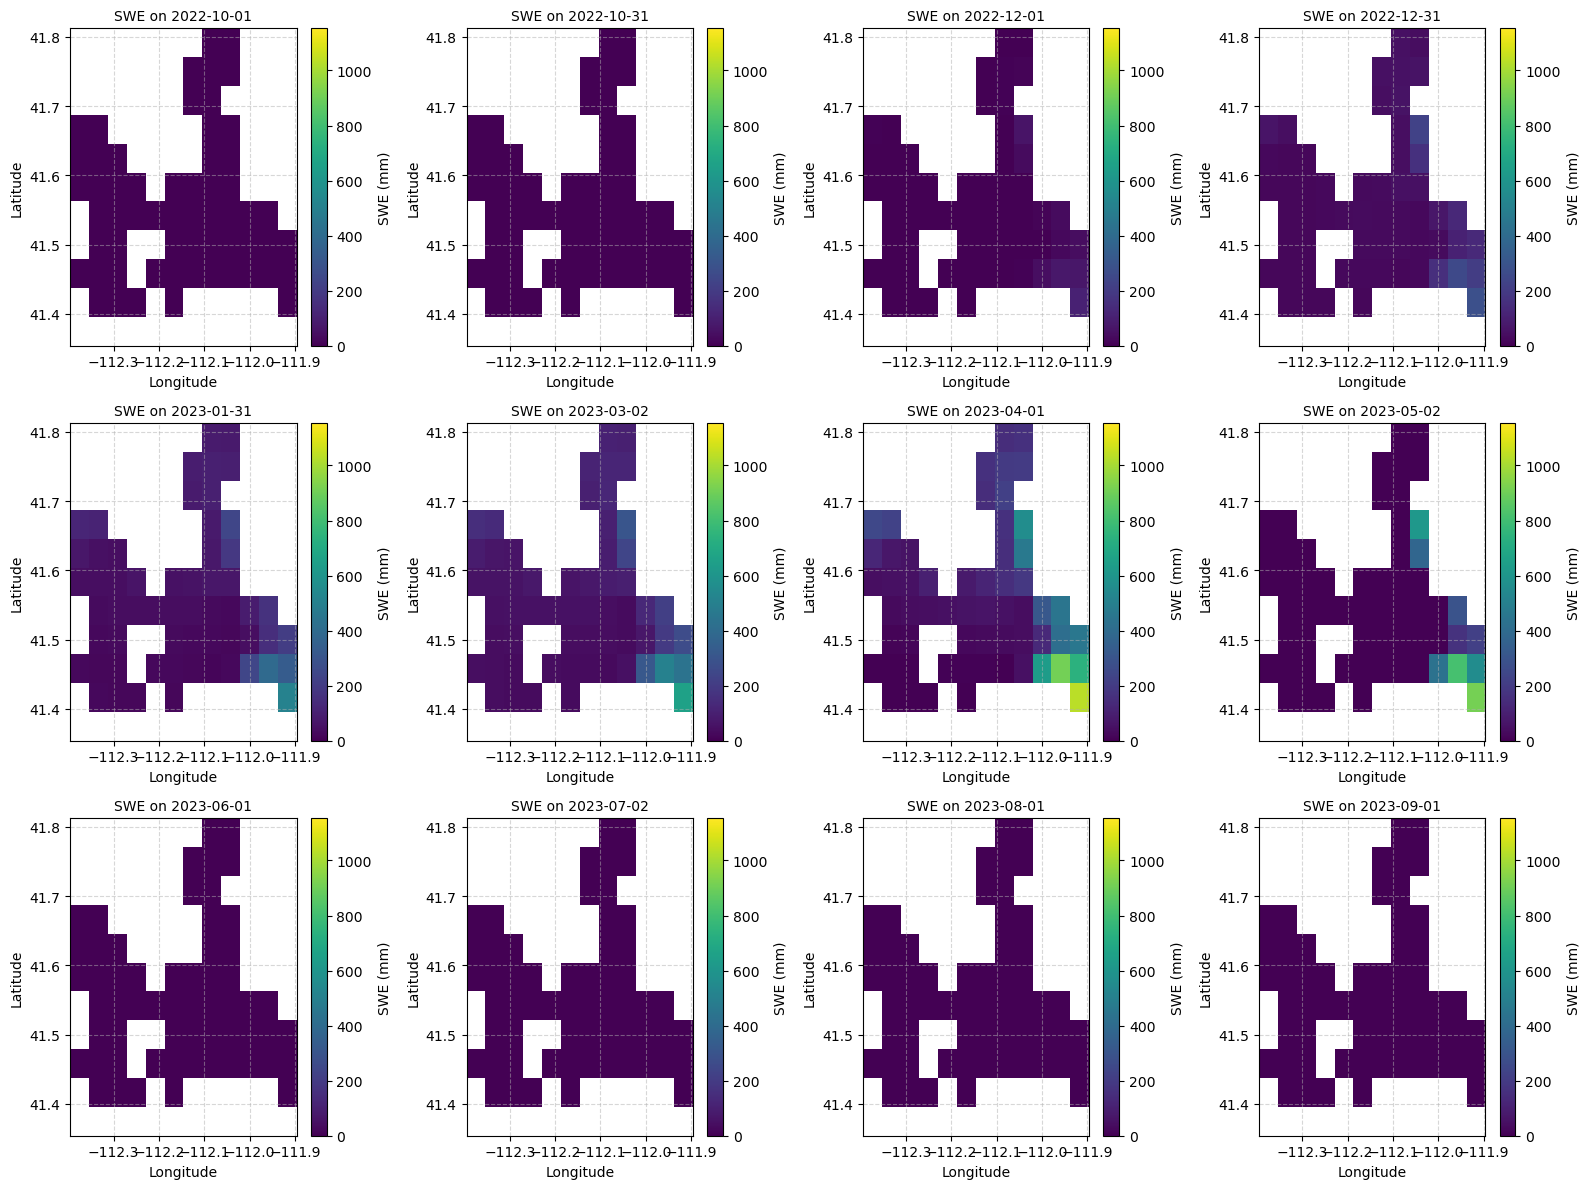

In [11]:
# Graph one year of SWE data 
#Using the example year above 
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 12))  # Adjust size as needed
axes = axes.flatten()  # Flatten to easily index axes

# Loop to create the plots
for i in range(12):  # Ensure the number of iterations matches the grid size
    swe_data = filtered_ds['SWE']
    time_slice = filtered_ds['time'].isel(time=round(i*365/12))
    swe_slice = filtered_ds['SWE'].sel(time=time_slice)
    swe_min = swe_data.min().values  # Get the minimum value of SWE
    swe_max = swe_data.max().values  # Get the maximum value of SWE
    
    ax = axes[i]  # Get the subplot axis for this iteration
    swe_slice.plot(
        ax=ax,
        x='lon', 
        y='lat', 
        vmin=swe_min,  # Set the minimum value of the colormap
        vmax=swe_max,  # Set the maximum value of the colormap
        cmap='viridis', 
        cbar_kwargs={'label': 'SWE (mm)'},  # Adjust units if necessary
    )
    
    # Add labels and title
    ax.set_title(f"SWE on {str(time_slice.values)[:10]}", fontsize=10)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.5)

# Remove unused subplots (if fewer than 12 plots)
for j in range(13, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



# Step 4 Calculate Basin Scale Mean 

In [12]:
# function to calculate the spatial mean and convert to a pandas dataframe
def ds_mean(ds):
    ds = ds.drop_vars(["spatial_ref", "crs", "DEPTH"])
    df = ds.mean(dim=['lat','lon']).to_dataframe()
    df = df.rename(columns=lambda col: f"mean_{col}")
    return df
    

In [13]:
# function to plot the SWE 
def plot_SWE(df, time_period): 
    plt.figure(figsize=(8, 4))
    plt.plot(df.index, df['mean_SWE']/1000, label='Mean SWE', color='blue', linewidth=2)

    # Add labels and title
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Mean SWE (m)', fontsize=12)
    plt.title(f'Mean SWE vs. Time for {time_period}', fontsize=14)

    # Improve plot appearance
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


In [14]:
# Example using the filtered_ds from above 
df = ds_mean(filtered_ds)
print(df.shape)
df.head()

(365, 1)


,mean_SWE
time,
2022-10-01,0.0
2022-10-02,0.0
2022-10-03,0.0
2022-10-04,0.0
2022-10-05,0.0


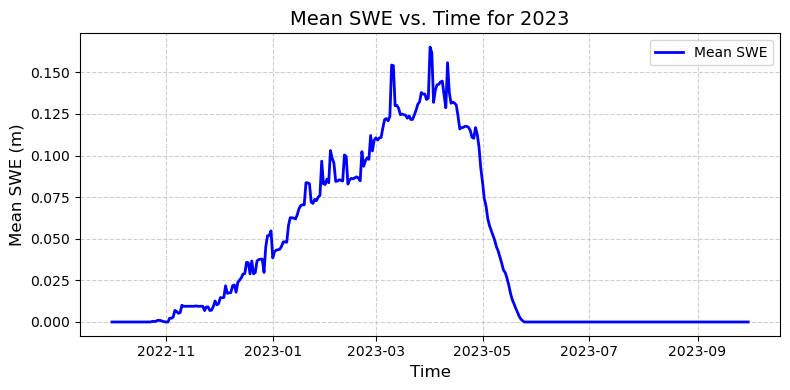

In [15]:
plot_SWE(df, YEAR)

# Step 5 Batch Processing

In [16]:
# Potential Years go from 1982 = 2023
YEAR_START = 1996
YEAR_END = 2012
years = list(range(YEAR_START, YEAR_END + 1))

geo = huc10_gdf.iloc[[0]]
geo_name = huc10_gdf.iloc[0]["name"]
print(geo_name)


Trout Creek-Bear River


In [17]:
start_time = time.time()
SWE_mean_df = pd.DataFrame()
for yr in years: 
    ds = download_year(yr)
    filtered_ds = fine_filter(ds, geo)
    df_mean = ds_mean(filtered_ds)
    SWE_mean_df = pd.concat([SWE_mean_df, df_mean])
    
f_out = f"{geo_name}_Mean_SWE_{YEAR_START}_{YEAR_END}.csv"
print(f"All done, saving file {f_out}")
SWE_mean_df.to_csv(f_out)
print(SWE_mean_df.shape)
SWE_mean_df.head()
end_time = time.time()
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

  
    

All done, saving file Trout Creek-Bear River_Mean_SWE_1996_2012.csv
(6210, 1)
Time elapsed: 111.43 seconds


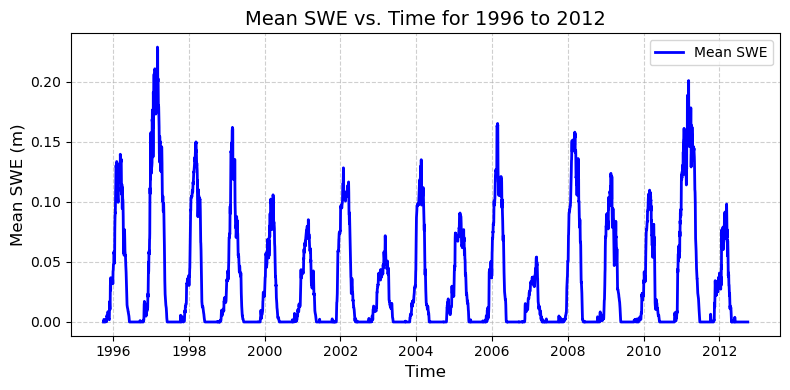

In [18]:
time_period = f"{years[0]} to {years[-1]}"
plot_SWE(SWE_mean_df, time_period)

In [19]:
SWE_mean_df.shape

(6210, 1)

# 